## Load in modules and functions

In [1]:
import cv2
import pandas as pd # for working with dataframes
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from pathlib import Path # for retrieving files from directory
import networkx as nx # for making graphs
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg # for images
from scipy.interpolate import interp1d # for interpolating points
from scipy.spatial import procrustes # for Procrustes analysis
from sklearn.decomposition import PCA # for principal component analysis
import seaborn as sns # for plotting in seaborn
import math # for math
from scipy.stats import zscore # for zscore

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def detect_pointy_tips(contour, window):
    """
    define a function to calculate how pointy each point in a contour is
    inputs: the contour and the window to define neighbors
    outputs: the angles of each contour point
    """
    pointy_tips = []
    for i in range(len(contour)):
        # Get the current point and its neighbors, defined by window
        p2 = contour[i]
        p3 = contour[(i + window) % len(contour)]
        p1 = contour[(i - window) % len(contour)]

        # Calculate the angle between the two vectors formed by the neighbors
        angle = angle_between(p1, p2, p3)

        # save current angle
        pointy_tips.append(angle)

    return pointy_tips

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean

def foo(a, start, stop): 
    # fn to convert start stop to a wrapped range
    if stop<=start:
        stop += len(a)
    return np.arange(start, stop)%len(a)

def average_contour_color(image, contour):
    """
    Calculates the average RGB color within a contour.

    Args:
        image (numpy.ndarray): The input image.
        contour (numpy.ndarray): The contour.

    Returns:
        tuple: The average BGR color (Blue, Green, Red).
    """
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    
    masked_image = cv2.bitwise_and(image, image, mask=mask)
  
    b, g, r = cv2.mean(masked_image, mask=mask)[:3]
    return (r, g, b)

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

At `threshx=50`, `min_area=10000`, `max_area=300000`, some minimum and maximum areas:  
`minimum`: 60000, 40000, 60000, 70000, 90000, 70000, 100000, 100000  
`maximum`: 130000, 90000, 120000, 140000, 170000, 160000, 160000, 180000

## Place landmarks

In [2]:
######################
### SET PARAMETERS ###
######################

data_dir = "./images/" # set data directory
land_dir = "./landmarks/" # set directory with landmarks
threshx = 50 # set threshold for segmentation
min_area = 10000 # minimum selection area
max_area = 300000 # maximum selection area
res = 203 # how many points to interpolate (ultimately res-1 points)
win = 60 # window size for detecting angles

kernel_list = [] # a list storing arrays of reoriented kernel data
name_list = [] # a list storing line names

#####################################################
#####################################################
#####################################################

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

if '.DS_Store' in file_names:
    file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names

line_names = [] # to store names of the lines
for i in range(len(file_names)): # for each file name
    line_names.append(file_names[i][:-4]) # store the line name

for z in range(len(line_names)): # for each line
#for z in range(5): # for a small number of lines

    # specify the line name
    name = line_names[z] 
    print(name)

    # load image and find contours
    image = cv2.imread(data_dir + name + '.jpg')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, threshx, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #########################################
    ### FILTER OUT CONTOURS BASED ON AREA ###
    #########################################

    conts = [] # store contours meeting filter area critera
    all_areas = [] # store all areas > 3 vertices
    filtered_areas = [] # store only areas meeting filter
    
    for i in range(len(contours)):
        if np.shape(contours[i])[0] > 3:
            con = np.reshape(contours[i], (np.shape(contours[i])[0], 2))
            all_areas.append(poly_area(con[:,0], con[:,1]))
            
        else:
            continue
    
        if (poly_area(con[:,0], con[:,1])<max_area) & (poly_area(con[:,0], con[:,1])>min_area):
            conts.append(con)
            filtered_areas.append(poly_area(con[:,0], con[:,1]))

    ####################################################
    ### INTERPOLATE AND MEASURE ANGLES AND DISTANCES ###
    ####################################################
    #-  Set resolution of interpolation
    #-  Add the first point to the last position of the contour, to close the contour
    #-  Interpolate
    #-  Remove last interpolated point (due to overlap)
    #-  For each point, calculate angle as defined by window, convert to z score
    #-  For each point, calcualte Euclidean distance to centroid, convert to z score
    #-  Save results as 4 dimensional array: x coordinate, y coordinate, angle z score, distance z score

    z_arr = np.zeros( (len(conts), res-1, 4))
    
    for i in range(len(conts)): # for each contour
    
        # select current contour
        curr_cont = conts[i]
        
        # close the contour
        closed_arr = np.zeros((len(curr_cont)+1,2))
        closed_arr[:-1] = curr_cont
        closed_arr[-1] = curr_cont[0]
        
        # calculate interpolated contour
        interp = np.column_stack(interpolation(closed_arr[:,0], closed_arr[:,1], res)) 
        
        # remove last point of interpolation
        interp = interp[:-1]
        
        # find angles for each contour point
        angs = detect_pointy_tips(interp, win)
        ang_z = zscore(angs)
    
        # find distances to centroid
        cent = np.mean(interp, axis=0)
    
        dists = []
        for j in range(len(interp)):
            dists.append(euclid_dist(cent[0],cent[1], interp[j][0], interp[j][1]))
        dist_z = zscore(dists)
            
        # store contour, angles, dists
        z_arr[i] = np.column_stack((interp, ang_z, dist_z))


    ################################
    ### ORIENT DATA TO LANDMARKS ###
    ################################
    #- for each contour, find the closest landmark
    #- reindex data so that the tip is index = 0

    # load in landmark data
    landmarks = np.loadtxt(land_dir + name + ".txt")
    
    oriented_arr = np.zeros(np.shape(z_arr)) # array to store oriented data
    
    for i in range(len(z_arr)):
    
        # retrieve the pseudo_landmarks
        pseudos = z_arr[i,:,0:2]
        
        l_inds = [] # store landmark indices
        p_inds = [] # store pseudo-landmark indices
        eds = [] # store euclidean distances
        
        for l in range(len(landmarks)): # for each landmark
            for p in range(len(pseudos)): # for each pseudo-landmark
        
                # calculate eulidean distance
                eds.append(euclid_dist(landmarks[l,0],landmarks[l,1],pseudos[p,0],pseudos[p,1]))
                # store landmark and pseudo-landmark indices
                l_inds.append(l)
                p_inds.append(p)
        
        min_ind = np.argmin(np.array(eds)) # find minimum index
        pseudo_ind = p_inds[min_ind] # find the pseudo_landmark index
    
        # re-index contour coords and angs and dists
        oriented_arr[i,:,:] = np.concatenate((z_arr[i,pseudo_ind:,:],z_arr[i,:pseudo_ind,:]))


    kernel_list.append(oriented_arr) # store oriented data

    names = [name] # store name data
    names = names*len(oriented_arr)
    name_list.append(names)

kernel_arr = np.concatenate(kernel_list) # create an array of kernel data
name_arr = np.concatenate(name_list) # create an array of kernel line name data

K_MEMA001
K_MEMA002
K_MEMA003
K_MEMA004
K_MEMA006
K_MEMA008
K_MEMA009
K_MEMA010
K_MEMA011
K_MEMA012
K_MEMA013
K_MEMA014
K_MEMA015
K_MEMA016
K_MEMA017
K_MEMA018
K_MEMA019
K_MEMA020
K_MEMA021
K_MEMA022
K_MEMA023
K_MEMA024
K_MEMA025
K_MEMA026
K_MEMA027
K_MEMA028
K_MEMA029
K_MEMA031
K_MEMA032
K_MEMA033
K_MEMA034
K_MEMA036
K_MEMA037
K_MEMA038
K_MEMA039
K_MEMA040
K_MEMA041
K_MEMA042
K_MEMA043
K_MEMA045
K_MEMA046
K_MEMA047
K_MEMA049
K_MEMA050
K_MEMA051
K_MEMA052
K_MEMA053
K_MEMA054
K_MEMA055
K_MEMA056
K_MEMA057
K_MEMA058
K_MEMA060
K_MEMA061
K_MEMA062
K_MEMA063
K_MEMA064
K_MEMA066
K_MEMA067
K_MEMA068
K_MEMA069
K_MEMA070
K_MEMA072


/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_74437/1818640739.py:95: RuntimeWarning: overflow encountered in scalar subtract
  return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))


K_MEMA073
K_MEMA074
K_MEMA075
K_MEMA076
K_MEMA077
K_MEMA078
K_MEMA079
K_MEMA080
K_MEMA082
K_MEMA083
K_MEMA085
K_MEMA087
K_MEMA088
K_MEMA089
K_MEMA090
K_MEMA091
K_MEMA092
K_MEMA093
K_MEMA094
K_MEMA095
K_MEMA096
K_MEMA097
K_MEMA098
K_MEMA100


Plot out kernels per line

There are 87 lines total.


<Axes: xlabel='count', ylabel='Count'>

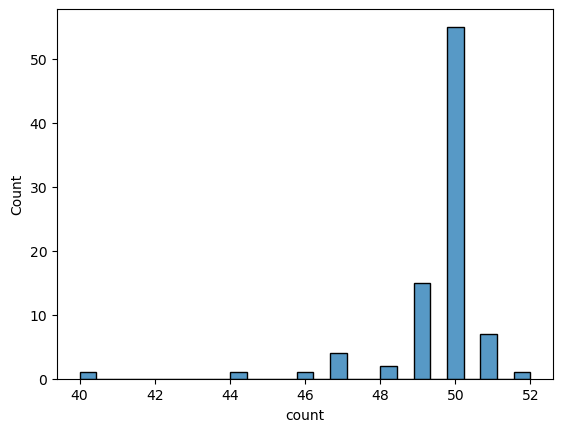

In [3]:
print("There are", len(np.unique(name_arr)), "lines total.")
sns.histplot(pd.DataFrame(name_arr).value_counts())

## Color

Define indices of polygons to retrieve color. Divide the kernel into intervals from tip to base

In [4]:
intervals = 10 # desired intervals to sample color
tip_ind = int((res-1)/2) # get the index of the tip

side1_inds = np.round(np.linspace(0,tip_ind,intervals+1)) # get side intervals
side2_inds = np.round(np.linspace(tip_ind,res-2,intervals+1))

# calculate boundaries of polygons
index_list = [] # store indices defining polygons
for i in range(intervals): # for the number of intervals
    pt1 = side1_inds[i] # define the 4 point
    pt2 = side1_inds[i+1]
    pt3 = side2_inds[intervals-i-1]
    pt4 = side2_inds[intervals-i]
    index_list.append([pt1,pt2,pt3,pt4]) # append to index list

# calculate indices of polygons
poly_inds = [] # store indices of polygons
for i in range(len(index_list)): # for each polygon
    # calculate all points for each polygon
    side1 = np.arange(index_list[i][0],index_list[i][1]+1,1)
    side2 = np.arange(index_list[i][2],index_list[i][3]+1,1)
    poly_inds.append(np.concatenate((side1,side2)).astype(int))

## SKIP THIS CELL IF PRE-CALCULATED COLOR
For each polygon, get average color values

In [6]:
col_dir = "./colors/" # set the directory to store the colors

for i in range(len(kernel_arr)): # for each kernel

    if i%50==0:
        print(i, "out of", len(kernel_arr))

    coords = kernel_arr[i,:,0:2] # get kernel shape
    name = name_arr[i] # get the genotype to get image
    
    image = cv2.imread(data_dir + name + '.jpg') # open image

    temp_rgb_arr = np.zeros( (intervals,3) )
    temp_hex_arr = np.zeros( (intervals) , dtype='U10') # arrays to store color information
    
    
    for j in range(intervals): # for each of the polygons
    
        poly_coords = coords[poly_inds[j],:] # get the polygon coordinates
        rgb_vals = average_contour_color(image, poly_coords.astype(int)) # get average rgb value
        int_rgb = tuple([int(x) for x in rgb_vals]) # convert rgb values into integer

        temp_rgb_arr[j,:] = int_rgb # store rgb values
        temp_hex_arr[j] = rgb_to_hex(int_rgb) # convert to hex color and store

    np.save(col_dir + str(i) + "_rgb.npy", temp_rgb_arr) # store rgb values
    np.save(col_dir + str(i) + "_hex.npy", temp_hex_arr) # store hex values


0 out of 4308


KeyboardInterrupt: 

## Read back in color information

In [5]:
col_dir = "./colors/" # set the directory to read in colors

hex_arr = np.zeros( (len(kernel_arr),intervals) , dtype='U10') # arrays to store color information
rgb_arr = np.zeros( (len(kernel_arr),intervals,3) )

for i in range(len(kernel_arr)): # for each kernel color profile

    if i%500==0:
        print(i, "out of", len(kernel_arr))

    hex_arr[i,:] = np.load(col_dir + str(i) + "_hex.npy") # store colors to array
    rgb_arr[i,:,:] = np.load(col_dir + str(i) + "_rgb.npy")

# save color arrays
np.save("hex_arr.npy", hex_arr)
np.save("rgb_arr.npy", rgb_arr)



0 out of 4308
500 out of 4308
1000 out of 4308
1500 out of 4308
2000 out of 4308
2500 out of 4308
3000 out of 4308
3500 out of 4308
4000 out of 4308


## Orientation and allometry

Convert to centimeter scale, translate to origin, rotate upwards, and calculate length, width, and area for each kernel

In [6]:
px_cm = 464 # set pixels per centimeter
cm_arr = kernel_arr[:,:,0:2]/px_cm # convert coordinates to centimeters
dim_arr = np.zeros((len(kernel_arr),4)) # an array to store dimensions: length, width, area, L-to-W ratio

#####################################################
#####################################################

for i in range(len(kernel_arr)): # for each kernel

    pts = cm_arr[i,:,:] # get points of current kernel
    centroid = np.mean(pts, axis=0) # get centroid
    pts = pts - centroid # zero center kernel
    
    tip_point = pts[tip_ind,:] # get tip point
    base_point = pts[0,:] # get base point
    
    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )
    
    # rotate points upwards
    rot_x, rot_y = rotate_points(pts[:,0], pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # calculate and store length, width, area, L/W in centimeters
    dim_arr[i,0] = np.max(rot_pts[:,1]) - np.min(rot_pts[:,1]) #LENGTH
    dim_arr[i,1] = np.max(rot_pts[:,0]) - np.min(rot_pts[:,0]) # WIDTH
    dim_arr[i,2] = poly_area(rot_pts[:,0],rot_pts[:,1]) # AREA
    dim_arr[i,3] = np.max(rot_pts[:,1]) - np.min(rot_pts[:,1])/np.max(rot_pts[:,0]) - np.min(rot_pts[:,0]) # L/W

    # store oriented and centimeter kernels back to kernel_arr
    kernel_arr[i,:,0:2] = rot_pts

## Evaluate distributions to remove outliers

Plot out distributions

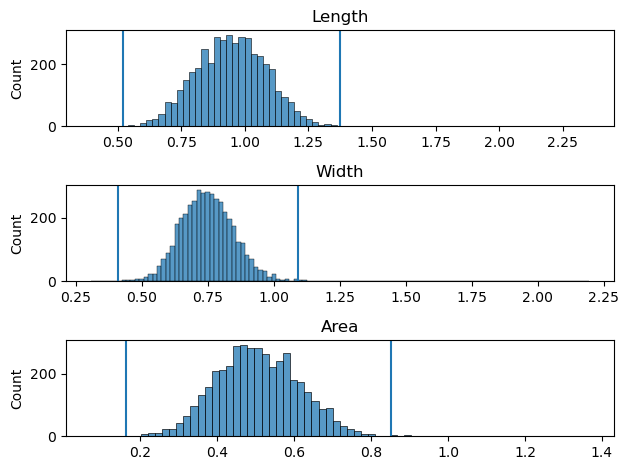

In [7]:
#########################################################################
nstd = 3.0 # number of standard deviations above/below to remove outliers
#########################################################################

# LENGTH
plt.subplot(3,1,1)
sns.histplot(dim_arr[:,0])
plt.axvline( np.mean(dim_arr[:,0])+nstd*np.std(dim_arr[:,0]), 0, 300)
plt.axvline( np.mean(dim_arr[:,0])-nstd*np.std(dim_arr[:,0]), 0, 300)
plt.title("Length")

# WIDTH
plt.subplot(3,1,2)
sns.histplot(dim_arr[:,1])
plt.axvline( np.mean(dim_arr[:,1])+nstd*np.std(dim_arr[:,1]), 0, 300)
plt.axvline( np.mean(dim_arr[:,1])-nstd*np.std(dim_arr[:,1]), 0, 300)
plt.title("Width")

# AREA
plt.subplot(3,1,3)
sns.histplot(dim_arr[:,2])
plt.axvline( np.mean(dim_arr[:,2])+nstd*np.std(dim_arr[:,2]), 0, 300)
plt.axvline( np.mean(dim_arr[:,2])-nstd*np.std(dim_arr[:,2]), 0, 300)
plt.title("Area")

plt.tight_layout()

Find the indices of outliers to delete

In [8]:
# find indices satisfying the condition

greater_length = np.argwhere(dim_arr[:,0]>(np.mean(dim_arr[:,0])+nstd*np.std(dim_arr[:,0])))
lesser_length = np.argwhere(dim_arr[:,0]<(np.mean(dim_arr[:,0])-nstd*np.std(dim_arr[:,0])))

greater_width = np.argwhere(dim_arr[:,1]>(np.mean(dim_arr[:,1])+nstd*np.std(dim_arr[:,1])))
lesser_width = np.argwhere(dim_arr[:,1]<(np.mean(dim_arr[:,1])-nstd*np.std(dim_arr[:,1])))

greater_area = np.argwhere(dim_arr[:,2]>(np.mean(dim_arr[:,2])+nstd*np.std(dim_arr[:,2])))
lesser_area = np.argwhere(dim_arr[:,2]<(np.mean(dim_arr[:,2])-nstd*np.std(dim_arr[:,2])))

# find unique indices to delete
outlier_indices = np.unique(np.concatenate((greater_width, lesser_width,
                          greater_length, lesser_length,
                          greater_area, lesser_area,
                         )))

# check that outliers are not one specific line
print(name_arr[outlier_indices])

# how many outliers are there?
print("There are", len(outlier_indices), "outliers for", nstd, "standard deviations")

['K_MEMA012' 'K_MEMA012' 'K_MEMA012' 'K_MEMA012' 'K_MEMA012' 'K_MEMA012'
 'K_MEMA014' 'K_MEMA017' 'K_MEMA019' 'K_MEMA020' 'K_MEMA024' 'K_MEMA024'
 'K_MEMA029' 'K_MEMA033' 'K_MEMA033' 'K_MEMA037' 'K_MEMA038' 'K_MEMA041'
 'K_MEMA045' 'K_MEMA046' 'K_MEMA046' 'K_MEMA046' 'K_MEMA053' 'K_MEMA063'
 'K_MEMA066' 'K_MEMA066' 'K_MEMA066' 'K_MEMA068' 'K_MEMA070' 'K_MEMA072'
 'K_MEMA087' 'K_MEMA090' 'K_MEMA091' 'K_MEMA092' 'K_MEMA092' 'K_MEMA098'
 'K_MEMA098']
There are 37 outliers for 3.0 standard deviations


Remove the outliers and create new arrays

In [9]:
new_name = np.delete(name_arr, outlier_indices, axis=0)
new_kernel = np.delete(kernel_arr, outlier_indices, axis=0)
new_rgb = np.delete(rgb_arr, outlier_indices, axis=0)
new_hex = np.delete(hex_arr, outlier_indices, axis=0)
new_dim = np.delete(dim_arr, outlier_indices, axis=0)

Calculate allometric models of length vs. width

In [10]:
names = np.unique(new_name) # get unique genotype names

allo_names = [] # store allometric model names
allo_funcs = [] # store allometric model functions
allo_xvals = [] # store allometric model xvals
allo_slopes = [] # store slopes of allometric models

for i in range(len(names)): # for each genotype

    curr_dims = new_dim[new_name==names[i]] # get dimension information for the current genotype

    # calculate linear coefficients for length as a function of width
    coefs = np.polyfit(curr_dims[:,1],curr_dims[:,0],1) 

    # calculate function from coefficients
    func = np.poly1d(coefs)

    # calculate the range of xvals (width)
    xvals = np.linspace(np.min(curr_dims[:,1]),np.max(curr_dims[:,1]), 100)

    # store allometric data
    allo_names.append(names[i])
    allo_funcs.append(func)
    allo_xvals.append(xvals)
    allo_slopes.append(coefs[0])
    

Plot out the histogram of slope values for each allometric model for each line

Text(0.5, 1.0, 'Allometric slope values, Length-to-Width')

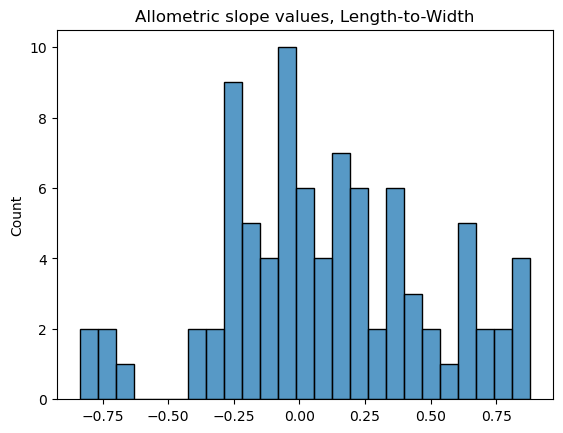

In [11]:
sns.histplot(allo_slopes, bins=25)
plt.title("Allometric slope values, Length-to-Width")

Plot allometric functions

Text(0, 0.5, 'length, cm')

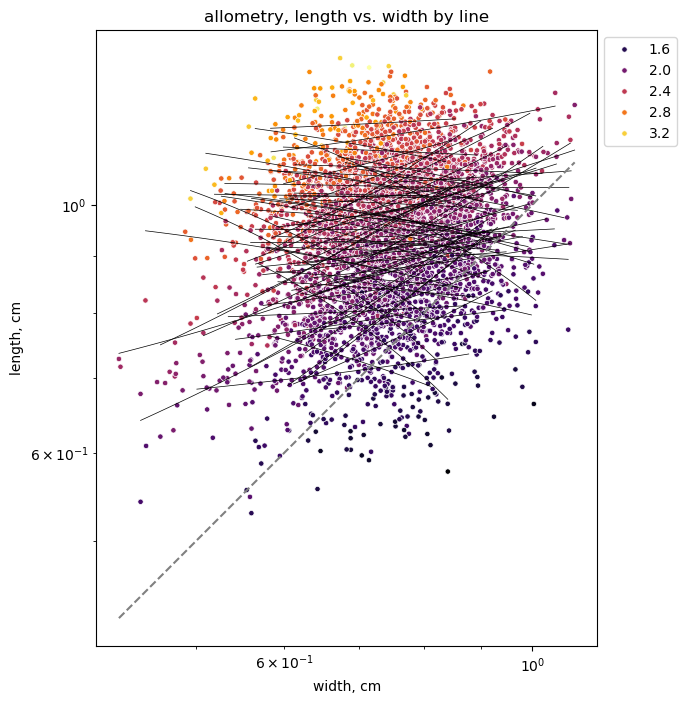

In [12]:
# create dataframe for plotting dimensions
allo_data = pd.DataFrame({"width":new_dim[:,1], "length":new_dim[:,0], "name":new_name})

# x and y vals for one-to-one line
xvals = np.linspace( np.min(new_dim[:,1]), np.max(new_dim[:,1]), 100)
yvals = xvals

plt.figure(figsize=(8,8)) # set figure size

ax = sns.scatterplot(data=allo_data, x="width", y="length", hue=new_dim[:,3], linewidth=0.5, s=15, palette="inferno") # plot dimension points

for i in range(len(allo_names)): # for each allometric model
    curr_func = allo_funcs[i] # get current function
    plt.plot(allo_xvals[i], curr_func(allo_xvals[i]), c="k", lw=0.5) # plot the function

# plot one-to-one line
plt.plot(xvals, yvals, c="gray", linestyle="dashed")
    
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # move legend outside plot
plt.xscale("log") # x axis log scale
plt.yscale("log") # y axis log scale
plt.gca().set_aspect("equal") # equal aspect ratio
plt.title("allometry, length vs. width by line") # title
plt.xlabel("width, cm") # x axis title
plt.ylabel("length, cm") # y axis title


Compare length and width models as a function of area

In [13]:
# length as a function of area
LA_coefs = np.polyfit(new_dim[:,2],new_dim[:,0],1) 
LA_func = np.poly1d(LA_coefs)

# width as a function of area
WA_coefs = np.polyfit(new_dim[:,2],new_dim[:,1],1) 
WA_func = np.poly1d(WA_coefs)

Text(0.5, 1.0, 'Length vs Area, blue, slope=0.96, inter=0.46\nWidth vs Area, orange, slope=0.68, inter=0.41')

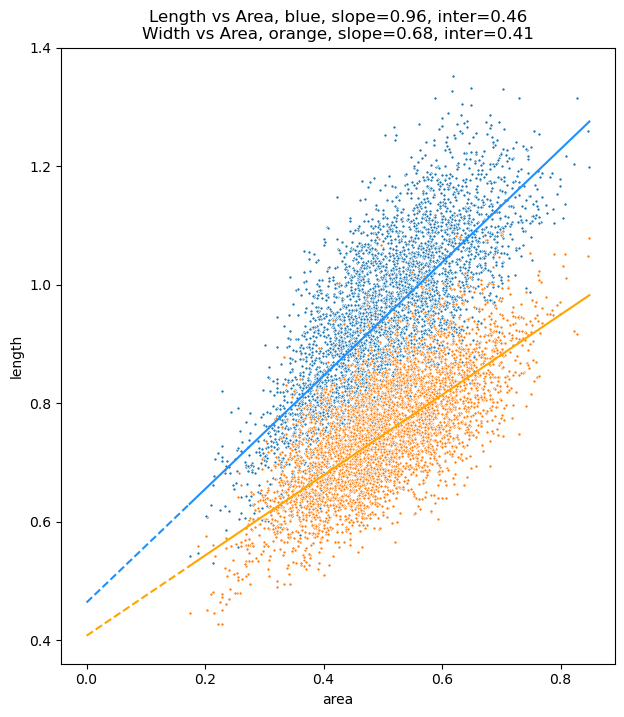

In [14]:
# create data frame of width, length, and area values
LWArea_df = pd.DataFrame({"width":new_dim[:,1], "length":new_dim[:,0], "area":new_dim[:,2], "name":new_name})

# calcualte min/max area for x values
xvals = np.linspace(np.min(new_dim[:,2]), np.max(new_dim[:,2]), 100)

# projected x vals to zero
proj_xvals = np.linspace(0,np.min(new_dim[:,2]), 100)

plt.figure(figsize=(8,8))

# plot out linear Length as function of Area 
plt.plot(xvals, LA_func(xvals), c="dodgerblue")
plt.plot(proj_xvals, LA_func(proj_xvals), c="dodgerblue", linestyle="--")
sns.scatterplot(data=LWArea_df, x="area", y="length", linewidth=0.5, s=5)
plt.gca().set_aspect("equal")

# plot out linear Width as function of Area 
plt.plot(xvals, WA_func(xvals), c="orange")
plt.plot(proj_xvals, WA_func(proj_xvals), c="orange", linestyle="--")
sns.scatterplot(data=LWArea_df, x="area", y="width", linewidth=0.5, s=5)
plt.gca().set_aspect("equal")

title = "Length vs Area, blue, slope=" + str(round(LA_coefs[0],2)) + ", inter=" + str(round(LA_coefs[1],2)) + "\n" + "Width vs Area, orange, slope=" + str(round(WA_coefs[0],2)) + ", inter=" + str(round(WA_coefs[1],2))

plt.title(title)

Mean shapes and colors by line

In [15]:
names = np.unique(new_name) # get unique genotype names

lw_ratio_arr = np.zeros((len(np.unique(new_name)))) # store average l

for i in range(len(names)): # for each genotype
    curr_LWs = new_dim[new_name==names[i],3] # get length-to-width ratios for current genotype
    lw_ratio_arr[i] = np.mean(curr_LWs) # save mean L-to-W ratio for each line

# get sorted L-to-W ratios indices
sorted_inds = np.argsort(lw_ratio_arr)

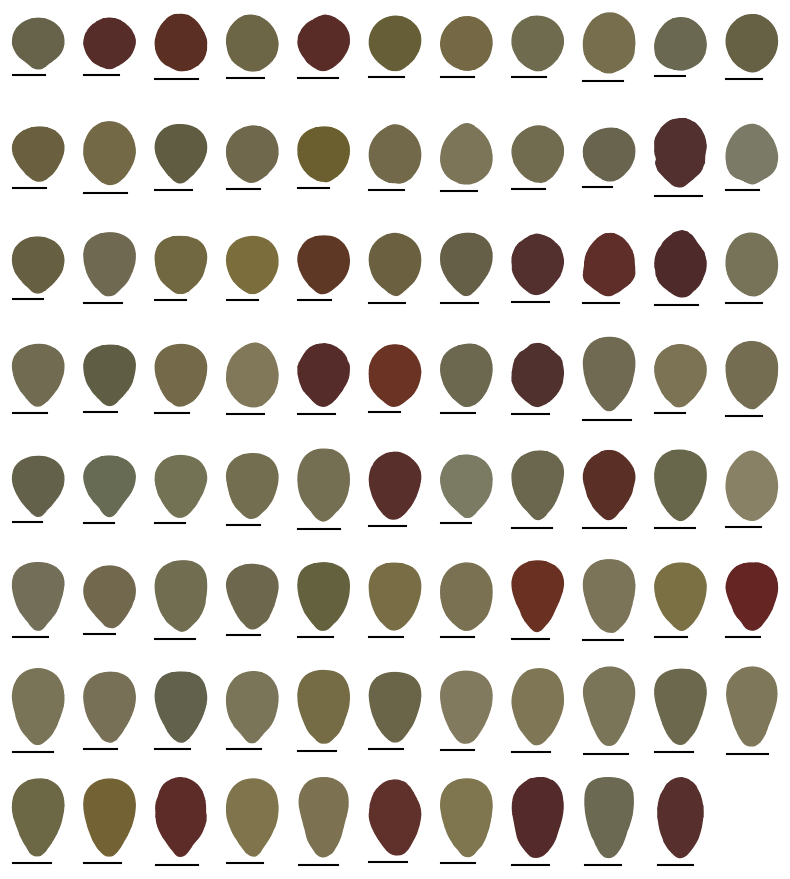

In [16]:
names = np.unique(new_name) # get unique genotype names
pad = 0.1 # padding to displace centimeter bar down
fig_rows = 8 # number of figure rows
fig_cols = 11 # number of figure cols

plt.figure(figsize=(8,9))

counter = 1

for i in sorted_inds: # for each genotype index, sorted by L-to-W ratio

    curr_coords = new_kernel[new_name==names[i],:,0:2] # get coordinates for the current genotype
    curr_rgb = new_rgb[new_name==names[i],:] # get rgb colors for current genotype

    mean_shape = np.mean(curr_coords, axis=0) # get mean coordinates
    
    mean_rgb = np.mean(curr_rgb, axis=0) # get mean rgb colors
    mean_hex_cols = [] # a list to store mean hex colors
    for k in range(len(mean_rgb)):
        int_rgb = tuple([int(x) for x in mean_rgb[k]]) # convert rgb values into integer
        mean_hex_cols.append( rgb_to_hex( int_rgb)) # convert to hex color and store
        
    plt.subplot(fig_rows,fig_cols,counter) 
    #plt.plot(mean_shape[:,0], mean_shape[:,1], c="k") # plot shape outline

    for j in range(len(poly_inds)):
        plt.fill( mean_shape[poly_inds[j],0], mean_shape[poly_inds[j], 1], c=mean_hex_cols[j])
    
    plt.plot( [np.min(mean_shape[:,0]),np.min(mean_shape[:,0])+0.5],
             [np.min(mean_shape[:,1])-pad,np.min(mean_shape[:,1])-pad], c="k") # plot 0.5 centimeter bar
    plt.gca().set_aspect("equal")
    #plt.title(names[i])
    plt.axis("off")
    plt.tight_layout()

    counter+=1




## Procrustes analysis

A Procrustes analysis in 2D: x and y coordinate values

In [17]:
landmark_num = res-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

# we will be analyzing just x and y coordinate values
# (not angles or distances. this is a 2D analysis)
just_coords = new_kernel[:,:,0:2] # isolate just the coordinate values
mean_shape = gpa_mean(just_coords, landmark_num, dim_num) # calculate the GPA mean shape

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(just_coords)) 

for i in range(len(new_kernel)):
    s1, s2, distance = procrustes(mean_shape, just_coords[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array

Plot the mean kernel shape

Text(0.5, 1.0, 'overall kernel')

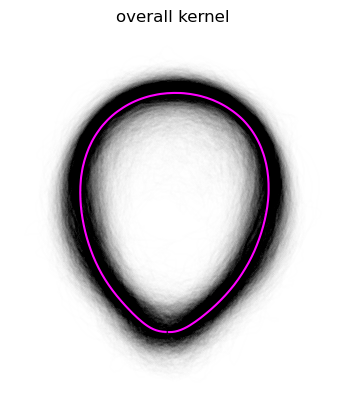

In [18]:
for i in range(len(proc_arr)):
    plt.plot(proc_arr[i,:,0], proc_arr[i,:,1], c="k", alpha=0.002)

plt.plot(np.mean(proc_arr, axis=0)[:,0], np.mean(proc_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("overall kernel")

## Principal Component Analysis and morphospace

Calculate variance for all PCs

In [19]:
# flatten the shape array into a single dimension for each kernel
flat_shape = np.reshape(proc_arr, (np.shape(proc_arr)[0], np.shape(proc_arr)[1]*np.shape(proc_arr)[2]))
print("There are", np.shape(flat_shape)[1], "shape features")

# flatten the rgb array into a single color profile for each kernel
flat_rgb = np.reshape(new_rgb, (np.shape(new_rgb)[0], np.shape(new_rgb)[1]*np.shape(new_rgb)[2]))
print("There are", np.shape(flat_rgb)[1], "color features")

# combine shape and color information into single array for pca
pca_arr = np.concatenate((flat_shape, flat_rgb), axis=1)

pca_all = PCA(n_components=np.min(np.shape(pca_arr))) # initiate a PCA
PCs_all = pca_all.fit_transform(pca_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )


There are 404 shape features
There are 30 color features
PC: var, overall 
PC1: 90.9%, 90.9%
PC2: 6.4%, 97.4%
PC3: 2.6%, 100.0%
PC4: 0.0%, 100.0%
PC5: 0.0%, 100.0%
PC6: 0.0%, 100.0%
PC7: 0.0%, 100.0%
PC8: 0.0%, 100.0%
PC9: 0.0%, 100.0%
PC10: 0.0%, 100.0%
PC11: 0.0%, 100.0%
PC12: 0.0%, 100.0%
PC13: 0.0%, 100.0%
PC14: 0.0%, 100.0%
PC15: 0.0%, 100.0%
PC16: 0.0%, 100.0%
PC17: 0.0%, 100.0%
PC18: 0.0%, 100.0%
PC19: 0.0%, 100.0%
PC20: 0.0%, 100.0%
PC21: 0.0%, 100.0%
PC22: 0.0%, 100.0%
PC23: 0.0%, 100.0%
PC24: 0.0%, 100.0%
PC25: 0.0%, 100.0%
PC26: 0.0%, 100.0%
PC27: 0.0%, 100.0%
PC28: 0.0%, 100.0%
PC29: 0.0%, 100.0%
PC30: 0.0%, 100.0%
PC31: 0.0%, 100.0%
PC32: 0.0%, 100.0%
PC33: 0.0%, 100.0%
PC34: 0.0%, 100.0%
PC35: 0.0%, 100.0%
PC36: 0.0%, 100.0%
PC37: 0.0%, 100.0%
PC38: 0.0%, 100.0%
PC39: 0.0%, 100.0%
PC40: 0.0%, 100.0%
PC41: 0.0%, 100.0%
PC42: 0.0%, 100.0%
PC43: 0.0%, 100.0%
PC44: 0.0%, 100.0%
PC45: 0.0%, 100.0%
PC46: 0.0%, 100.0%
PC47: 0.0%, 100.0%
PC48: 0.0%, 100.0%
PC49: 0.0%, 100.0%
PC50

Calculate a PCA in 2 dimensions for morphospace

In [20]:
pca = PCA(n_components=2) # initiate a PCA for morphospace
PCs = pca.fit_transform(pca_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )

# create a df of PC values and label for plotting
PC_df = pd.DataFrame({"PC1":PCs[:,0], "PC2":PCs[:,1], "genotype":new_name, "LW":new_dim[:,3]})

PC: var, overall 
PC1: 90.9%, 90.9%
PC2: 6.4%, 97.4%


Calculate morphospace

Text(0.5, 1.0, 'Procrustean shape + color morphospace')

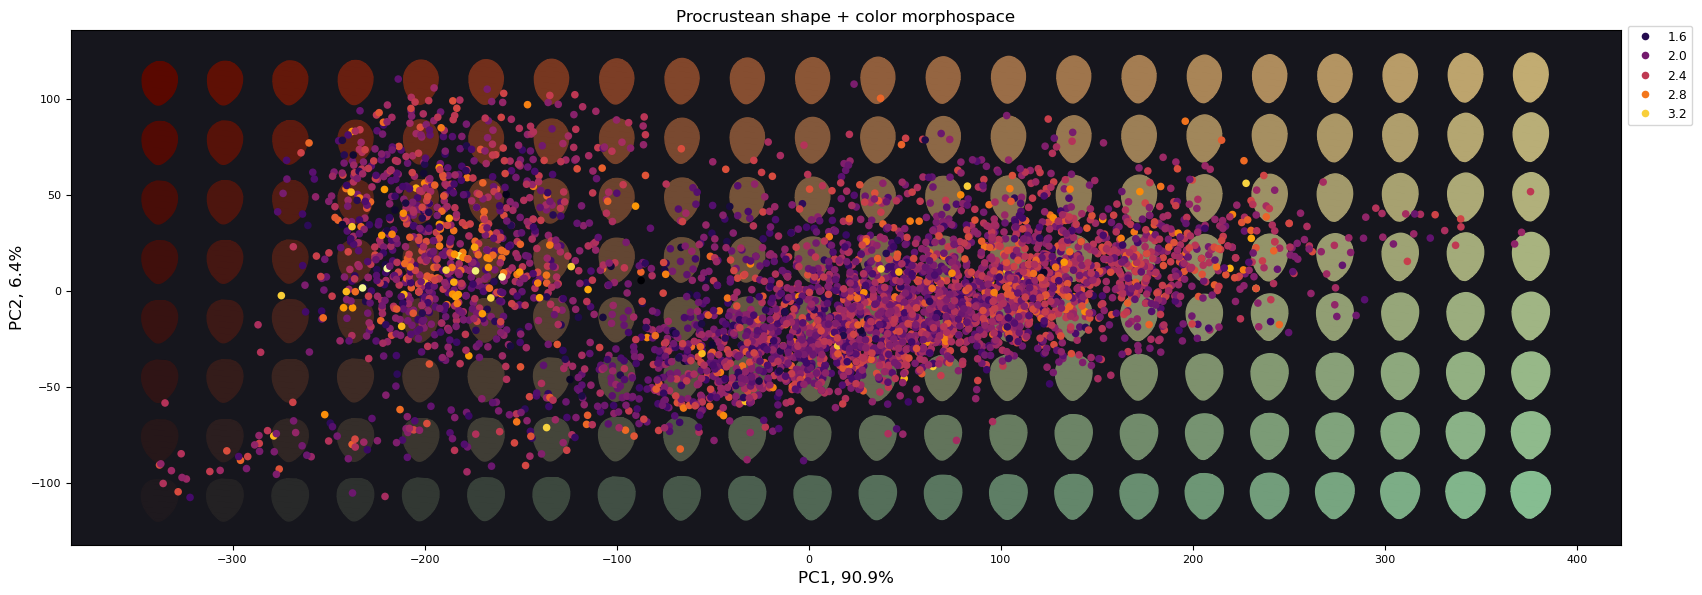

In [21]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 20 # plot length in inches
plot_width= 10 # plot width in inches
numPC1 = 22 # set number of PC1 intervals
numPC2 = 8 # set number of PC2 intervals
hue = "LW" # select the factor to color by
s = 150 # set the scale of the eigenkernels
lf_col = "lightgray" # color of inverse eigenkernels
lf_alpha = 1 # alpha of inverse eigenleaf
pt_size = 30 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 1 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "#16161d" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean shape + color morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenkernel
        inv_kernel = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_kernel[0:np.shape(flat_shape)[1]:2] # select just inverse x vals
        inv_y = inv_kernel[1:np.shape(flat_shape)[1]:2] # select just inverse y vals

        # calculate the inverse eigencolors
        inv_color = inv_kernel[np.shape(flat_shape)[1]:]
        inv_rgb = np.reshape(inv_color, (intervals,3))
        inv_rgb[inv_rgb < 0] = 0
        inv_rgb[inv_rgb > 255] = 255
        
        mean_hex_cols = [] # a list to store mean hex colors
        for k in range(len(inv_rgb)):
            int_rgb = tuple([int(x) for x in inv_rgb[k]]) # convert rgb values into integer
            mean_hex_cols.append( rgb_to_hex( int_rgb)) # convert to hex color and store
        
        # plot the inverse eigenkernel
        for l in range(len(poly_inds)):
            plt.fill(inv_x[poly_inds[l]]*s+pc1_val, inv_y[poly_inds[l]]*s+pc2_val, c=mean_hex_cols[l], alpha=lf_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=PC_df, x="PC1", y="PC2", hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha, legend=True, palette="inferno")

plt.legend(bbox_to_anchor=(1.05, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.gca().set_axisbelow(True)
plt.title(title)



## Load in image
Note the setting of the grayscale threshold level. It had to be lowered for the darker kernel example. We should probably investigate color or more sophisticated thresholding

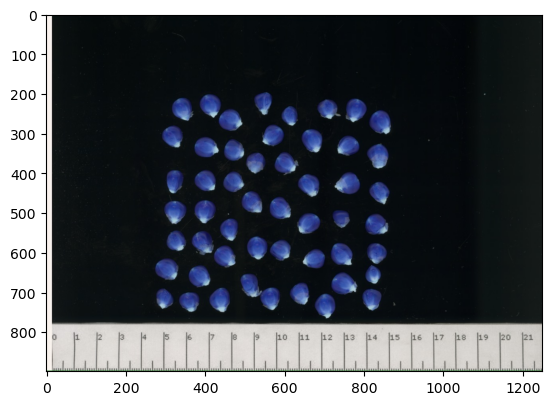

In [92]:
# Specify the file name
name = "geno2"

# Set threshold
thresh = 50

# Load image and find contours
image = cv2.imread(name + '.jpeg')
plt.imshow(image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Visualize the thresholding.

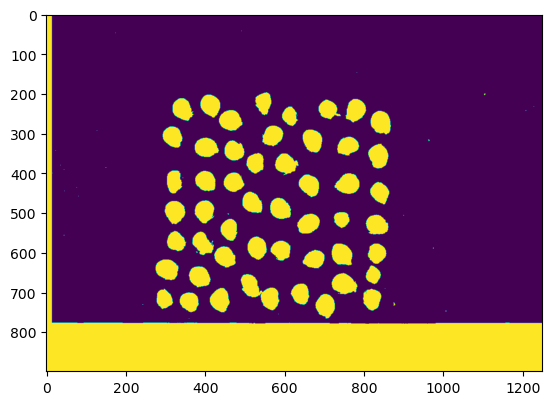

In [93]:
plt.imshow(thresh)

## Filter thresholded contours by area
Filter our contours below/above certain area, or below 3 vertices

In [94]:
min_area = 500
max_area = 3000

conts = []
all_areas = []
filtered_areas = [] 

for i in range(len(contours)):
    if np.shape(contours[i])[0] > 3:
        con = np.reshape(contours[i], (np.shape(contours[i])[0], 2))
        all_areas.append(poly_area(con[:,0], con[:,1]))
        
    else:
        continue

    if (poly_area(con[:,0], con[:,1])<max_area) & (poly_area(con[:,0], con[:,1])>min_area):
        conts.append(con)
        filtered_areas.append(poly_area(con[:,0], con[:,1]))

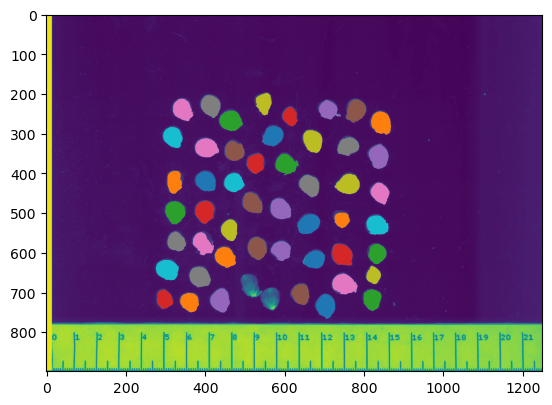

In [95]:
plt.imshow(gray)

for i in range(len(conts)):
    plt.fill(conts[i][:,0],conts[i][:,1])

## Interpolate pseudo-landmarks and measure angles/distances to centroids
-  Set resolution of interpolation
-  Add the first point to the last position of the contour, to close the contour
-  Interpolate
-  Remove last interpolated point (due to overlap)
-  For each point, calculate angle as defined by window, convert to z score
-  For each point, calcualte Euclidean distance to centroid, convert to z score
-  Save results as 4 dimensional array: x coordinate, y coordinate, angle z score, distance z score

In [96]:
res = 201 # how many points to interpolate
win = 60 # window size for detecting angles

z_arr = np.zeros( (len(conts), res-1, 4))

for i in range(len(conts)): # for each contour

    # select current contour
    curr_cont = conts[i]
    
    # close the contour
    closed_arr = np.zeros((len(curr_cont)+1,2))
    closed_arr[:-1] = curr_cont
    closed_arr[-1] = curr_cont[0]
    
    # calculate interpolated contour
    interp = np.column_stack(interpolation(closed_arr[:,0], closed_arr[:,1], res)) 
    
    # remove last point of interpolation
    interp = interp[:-1]
    
    # find angles for each contour point
    angs = detect_pointy_tips(interp, win)
    ang_z = zscore(angs)

    # find distances to centroid
    cent = np.mean(interp, axis=0)

    dists = []
    for j in range(len(interp)):
        dists.append(euclid_dist(cent[0],cent[1], interp[j][0], interp[j][1]))
    dist_z = zscore(dists)
        
    # store contour, angles, dists
    z_arr[i] = np.column_stack((interp, ang_z, dist_z))

Visualize angles around contours

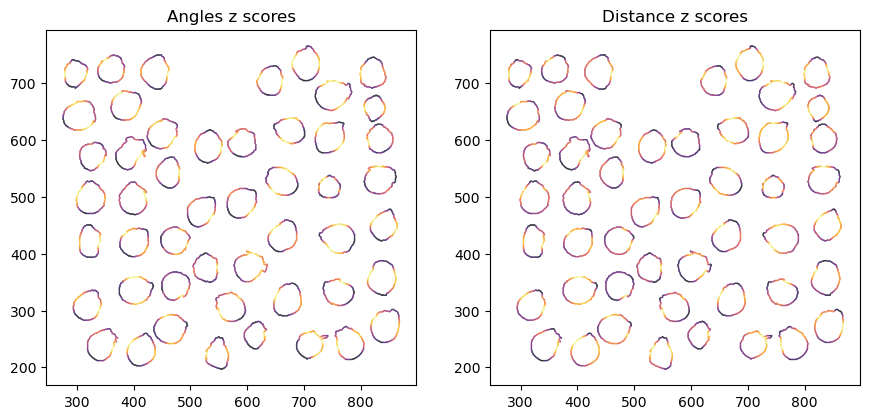

In [97]:
#plt.imshow(image, alpha=0.5)

plt.figure(figsize=(10.5,5))

for i in range(len(z_arr)):
    curr_ker = z_arr[i,:,:]

    plt.subplot(1,2,1)
    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,2], s=1, legend=False, palette="inferno_r")
    plt.gca().set_aspect("equal")
    plt.title("Angles z scores")

    plt.subplot(1,2,2)
    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,3], s=1, legend=False, palette="inferno_r")
    plt.gca().set_aspect("equal")
    plt.title("Distance z scores")



In [98]:
landmarks = np.loadtxt(name + ".txt")

oriented_arr = np.zeros(np.shape(z_arr))

for i in range(len(z_arr)):

    # retrieve the pseudo_landmarks
    pseudos = z_arr[i,:,0:2]
    
    l_inds = [] # store landmark indices
    p_inds = [] # store pseudo-landmark indices
    eds = [] # store euclidean distances
    
    for l in range(len(landmarks)): # for each landmark
        for p in range(len(pseudos)): # for each pseudo-landmark
    
            # calculate eulidean distance
            eds.append(euclid_dist(landmarks[l,0],landmarks[l,1],pseudos[p,0],pseudos[p,1]))
            # store landmark and pseudo-landmark indices
            l_inds.append(l)
            p_inds.append(p)
    
    min_ind = np.argmin(np.array(eds)) # find minimum index
    pseudo_ind = p_inds[min_ind] # find the pseudo_landmark index

    # re-index contour coords and angs and dists
    oriented_arr[i,:,:] = np.concatenate((z_arr[i,pseudo_ind:,:],z_arr[i,:pseudo_ind,:]))



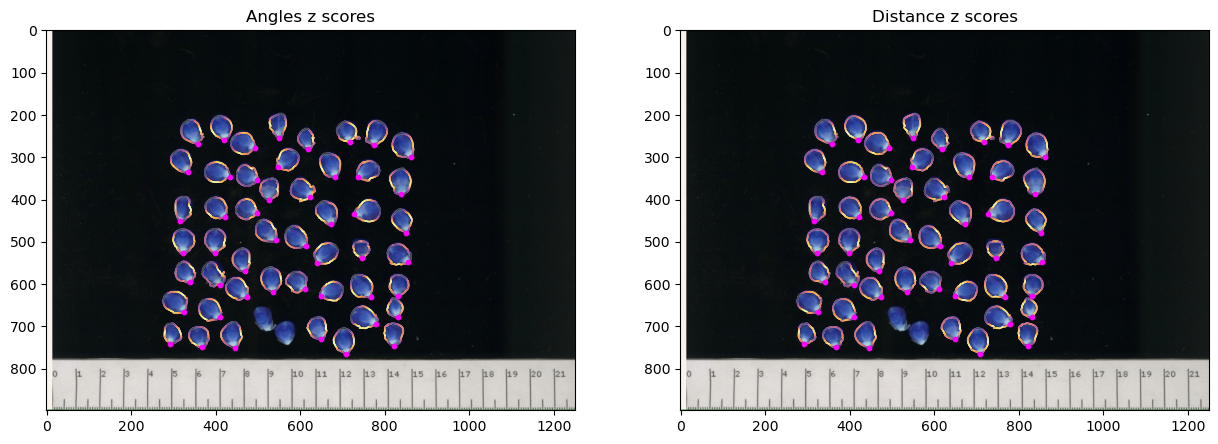

In [99]:
pt_s = 10 # point size
img_a = 0.2 # image alpha

plt.figure(figsize=(15,5))

for i in range(len(z_arr)):
    curr_ker = oriented_arr[i,:,:]

    plt.subplot(1,2,1)
    plt.imshow(image, alpha=img_a)
    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,2], s=1, legend=False, palette="inferno_r")
    plt.scatter(curr_ker[0,0], curr_ker[0,1], c="magenta", s=pt_s)
    plt.gca().set_aspect("equal")
    plt.title("Angles z scores")

    plt.subplot(1,2,2)
    plt.imshow(image, alpha=img_a)
    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,3], s=1, legend=False, palette="inferno_r")
    plt.scatter(curr_ker[0,0], curr_ker[0,1], c="magenta", s=pt_s)
    plt.gca().set_aspect("equal")
    plt.title("Distance z scores")

## Detect landmarks
- Smooth out angles for a given window size
- Smooth out distances for a given window size
- For smoothened angles as a function of pseudo-landmark, there will be two positive peaks (tip/base) and two negative peaks (the sides)
- Set a positive/negative threshold. Find intersections with each threshold. There should be 8 interesections (or, 4 crossings of the zero mark of the angular z score).
- If there are not 8 intersections detected, ignore the current kernel.
- Find the midpoint indices between each of the intersection points, which will be the landmarks (also 8)
- For the two positive angular z score peaks, these will be the tip/base. The tip is defined as having a higher value of (smoothened angle minus smoothened distance value), and the tip as having the lesser value
- Save the eight landmark indices in order: TIP, BORDER, SIDE, BORDER, BASE, BORDER, SIDE, BORDER 

In [8]:
thresh = 0.1 # threshold to call peaks
rwin = 10 # window for smoothing z scores

leaf_list = [] # processed leaves
landmarks = [] # indices of landmarks
smooth_ang_list = [] # list to store smoothened angles
smooth_dist_list = [] # list to store smoothened distances

for i in range(len(z_arr)): # for each kernel

    a = z_arr[i,:,2] # get current kernel angles
    smooth_ang = [] # calculate smoothened z scores angles
    for j in range(len(a)):
        rolled = np.roll(a, -j)
        roll_window = rolled[:rwin]
        smooth_ang.append(np.mean(roll_window))
    
    d = z_arr[i,:,3] # get current kernel distances
    smooth_dist = [] # calculate smoothened z scores distances
    for k in range(len(d)):
        rolled = np.roll(d, -k)
        roll_window = rolled[:rwin]
        smooth_dist.append(np.mean(roll_window))
    
    # Find intersection indices with thresholds
    positive_intersection = np.where(np.diff(np.sign(np.array(smooth_ang) - thresh)))[0]
    negative_intersection = np.where(np.diff(np.sign(np.array(smooth_ang) + thresh)))[0]
    inter = np.concatenate((negative_intersection, positive_intersection))
    inter.sort()

    # if 8 intersections are not detected, ignore
    if len(inter)!=8:
        continue
    
    # create an array of the indices
    ind_arr = np.arange(0,res-1)
    
    # find landmarks as midpoint values
    landmark_indices = [] 
    for l in range(8):
        indices = foo(ind_arr, inter[l%8], inter[(l+1)%8]+1)
        #index_list.append(inter[l%8])
        landmark_indices.append(indices[len(indices)//2])
    
    # find smooth_ang and smooth_dist values for indices
    smooth_ang_vals = [smooth_ang[i] for i in landmark_indices]
    smooth_dist_vals = [smooth_dist[i] for i in landmark_indices]
    
    # sort smooth_ang values (negative to positive)
    sorted_indices = np.argsort(smooth_ang_vals)
    
    # find the tip and base index (the index of landmark_indices that is the tip or base)
    if (smooth_ang_vals[sorted_indices[-1]]-smooth_dist_vals[sorted_indices[-1]]) > (smooth_ang_vals[sorted_indices[-2]]-smooth_dist_vals[sorted_indices[-2]]):
        tip_index = sorted_indices[-1]
        base_index = sorted_indices[-2]
    else:
        tip_index = sorted_indices[-2]
        base_index = sorted_indices[-1]
    
    # reindex landmarks starting at tip
    # TIP, BORDER, SIDE, BORDER, BASE, BORDER, SIDE, BORDER
    indices_from_tip = np.concatenate(  (landmark_indices[tip_index:],landmark_indices[:tip_index] ) )

    leaf_list.append(i)
    landmarks.append(indices_from_tip)
    smooth_ang_list.append(smooth_ang)
    smooth_dist_list.append(smooth_dist)


## Visualize placed landmarks

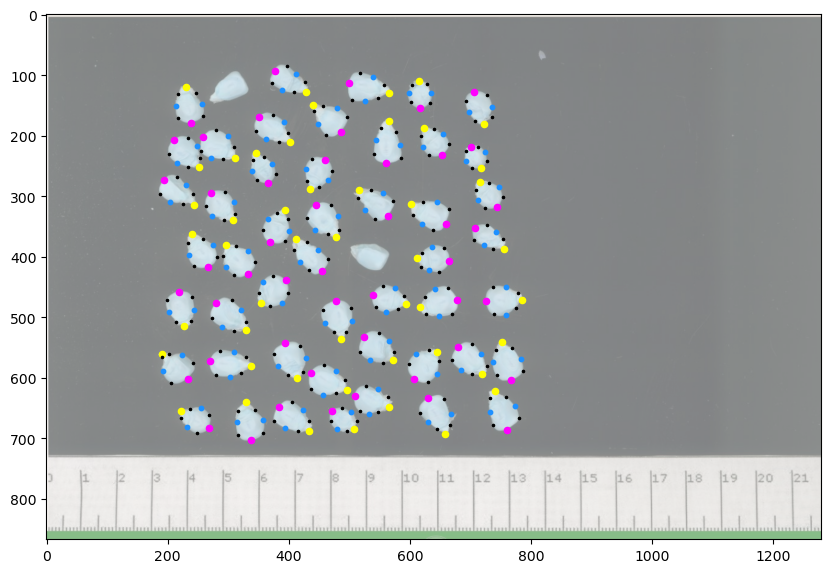

In [9]:
pt_size=5

plt.figure(figsize=(10,10))
plt.imshow(image, alpha=0.5)

#for i in range(len(z_arr)):
#    curr_ker = z_arr[i,:,:]

#    sns.scatterplot(x=curr_ker[:,0], y=curr_ker[:,1], hue=curr_ker[:,2], s=1, legend=False, palette="inferno_r")
#    plt.gca().set_aspect("equal")

for j in range(len(leaf_list)):

    curr_leaf = z_arr[leaf_list[j]]
    curr_landmarks = landmarks[j]
    
    tip_index = int(curr_landmarks[0])
    base_index = int(curr_landmarks[4])
    side_index1 = int(curr_landmarks[2])
    side_index2 = int(curr_landmarks[6])
    border_index1 = int(curr_landmarks[1])
    border_index2 = int(curr_landmarks[3])
    border_index3 = int(curr_landmarks[5])
    border_index4 = int(curr_landmarks[7])

    plt.scatter(curr_leaf[tip_index][0], curr_leaf[tip_index][1], c="magenta", s=pt_size*4)
    plt.scatter(curr_leaf[base_index][0], curr_leaf[base_index][1], c="yellow", s=pt_size*4)
    plt.scatter(curr_leaf[side_index1][0], curr_leaf[side_index1][1], c="dodgerblue", s=pt_size*2)
    plt.scatter(curr_leaf[side_index2][0], curr_leaf[side_index2][1], c="dodgerblue", s=pt_size*2)

    plt.scatter(curr_leaf[border_index1][0], curr_leaf[border_index1][1], c="k", s=pt_size/2)
    plt.scatter(curr_leaf[border_index2][0], curr_leaf[border_index2][1], c="k", s=pt_size/2)
    plt.scatter(curr_leaf[border_index3][0], curr_leaf[border_index3][1], c="k", s=pt_size/2)
    plt.scatter(curr_leaf[border_index4][0], curr_leaf[border_index4][1], c="k", s=pt_size/2)


## Visualize angular, angular-distance values
Evaluating angle and angle-distance across the contour might be a better way to orient and assign landmark positions

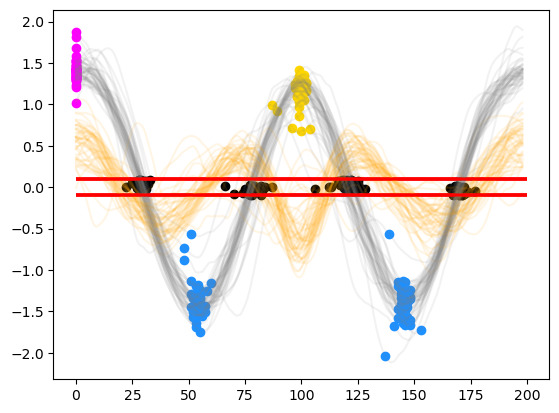

In [10]:
for i in range(len(leaf_list)):

    new_ind = int(landmarks[i][0]) # new index to reindex data to, starting at tip
    
    coords = z_arr[leaf_list[i],:,:2] # get current leaf coordinates
    angs = smooth_ang_list[i] # get current leaf angles
    dists = smooth_dist_list[i] # get current leaf distances
    angs_dists = np.array(angs)-np.array(dists) # calculate angle-distance values
    x_vals = np.arange(0,len(angs),1) # indices for plotting
    new_lands = (landmarks[i]-new_ind) % len(angs) # landmarks reindexed with the tip at zero
    new_lands = new_lands.astype(int)
    
    new_angs = np.concatenate((angs[new_ind:],angs[:new_ind]))
    new_ang_dists = np.concatenate((angs_dists[new_ind:],angs_dists[:new_ind]))
    
    plt.plot(x_vals, new_angs, c="gray", alpha=0.1)
    plt.plot(x_vals, new_ang_dists, c="orange", alpha=0.1)
    
    # TIP, BORDER, SIDE, BORDER, BASE, BORDER, SIDE, BORDER
    plt.scatter(new_lands[0], new_angs[new_lands[0]], c="magenta")
    plt.scatter(new_lands[1], new_angs[new_lands[1]], c="k")
    plt.scatter(new_lands[2], new_angs[new_lands[2]], c="dodgerblue")
    plt.scatter(new_lands[3], new_angs[new_lands[3]], c="k")
    plt.scatter(new_lands[4], new_angs[new_lands[4]], c="gold")
    plt.scatter(new_lands[5], new_angs[new_lands[5]], c="k")
    plt.scatter(new_lands[6], new_angs[new_lands[6]], c="dodgerblue")
    plt.scatter(new_lands[7], new_angs[new_lands[7]], c="k")
    
    plt.hlines(thresh, 0, 200, "r")
    plt.hlines(-thresh, 0, 200, "r")